In [1]:
import pandas as pd
import preprocessing as pp
import numpy as np
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import utils as utils

In [2]:
import random
seed = 100
np.random.seed(seed)
random.seed(seed)

In [3]:
X, y = utils.importar_datos()

- Se utilizan los mejores modelos obtenidos para XGBoost, Random Forest y SVM

In [4]:
def random_forest():
    preprocessor = pp.PreprocessingLE()
    model = RandomForestClassifier(random_state=pp.RANDOM_STATE, 
                                   n_jobs=-1, 
                                   max_depth=8, 
                                   min_samples_leaf=1, 
                                   min_samples_split=14, 
                                   max_features=7)
    pipeline = Pipeline([("preprocessor", preprocessor), 
                         ("model", model)
                         ])
    return pipeline

In [5]:
def xgboost():
    pipeline = Pipeline([
    ("preprocessor", pp.PreprocessingLE()),
    ("model", XGBClassifier(use_label_encoder=False, scale_pos_weight=1, subsample=0.8, colsample_bytree=0.8,
                            objective="binary:logistic", n_estimators=1000, learning_rate=0.01, n_jobs=-1,
                            eval_metric="logloss", min_child_weight=6, max_depth=6, reg_alpha=0.05))
    ])
    return pipeline

In [6]:
def svm():
    preprocessor = pp.PreprocessingSE()
    model = SVC(kernel='rbf', random_state=pp.RANDOM_STATE, C=1, gamma='scale', probability=True)
    pipeline = Pipeline([("preprocessor", preprocessor), 
                     ("model", model)
                     ])
    return pipeline

### Modelo 1

- Se utiliza un ensamble de tipo Stacking
- Como estimador final se usa un GaussianNB


In [7]:
def stacking_gaussian(var_smoothing=1e-9):
    estimadores = [('svm', svm()), ('xgboost', xgboost()), ('random_forest', random_forest())]
    cv = utils.kfold_for_cross_validation()
    stacking = StackingClassifier(estimators=estimadores, final_estimator=GaussianNB(var_smoothing=var_smoothing), 
                                  stack_method="predict_proba", cv=cv)
    return stacking

In [8]:
stacking = stacking_gaussian()

#### Metricas

In [9]:
utils.metricas_cross_validation(X, y, stacking)

,Mean,Std,Oof,Max,Min
roc auc,0.867432,0.028982,0.861596,0.902377,0.817912
accuracy,0.816473,0.019377,0.816479,0.840000,0.770000
precision,0.783457,0.037506,0.781690,0.848485,0.710526
recall,0.723178,0.025118,0.723127,0.763158,0.684211
f1 score,0.751482,0.022270,0.751269,0.777778,0.701299


### Modelo 2

- Mismo tipo de ensamble
- Mismo estimador final que en el modelo 1, pero se busca un mejor hiperparámetro para el GaussianNB.


In [10]:
stacking = stacking_gaussian()

In [11]:
#params = {
#    'final_estimator__var_smoothing': [1e-9, 1e-7, 1e-6, 1e-3, 5e-3, 1e-2, 0.1, 0.3],
#    'xgboost__model__use_label_encoder': [False], 
#    'xgboost__model__scale_pos_weight': [1], 
#    'xgboost__model__subsample': [0.8], 
#    'xgboost__model__colsample_bytree': [0.8],
#    'xgboost__model__objective': ["binary:logistic"], 
#    'xgboost__model__n_estimators': [1000], 
#    'xgboost__model__learning_rate': [0.01], 
#    'xgboost__model__n_jobs': [-1],                       
#    'xgboost__model__eval_metric': ["logloss"], 
#    'xgboost__model__min_child_weight': [6], 
#    'xgboost__model__max_depth': [6], 
#    'xgboost__model__reg_alpha': [0.05],
#    'svm__model__C': [1], 
#    'svm__model__gamma': ['scale'], 
#    'svm__model__probability': [True],
#    'svm__model__random_state': [pp.RANDOM_STATE], 
#    'random_forest__model__n_jobs': [-1], 
#    'random_forest__model__max_depth': [11], 
#    'random_forest__model__min_samples_leaf': [1], 
#    'random_forest__model__min_samples_split': [13]
#}

#cv = StratifiedKFold(n_splits=8, random_state=pp.RANDOM_STATE, shuffle=True)
#gscv_gaussian = GridSearchCV(
#    stacking, params, scoring='roc_auc', n_jobs=-1, cv=cv, return_train_score=True
#).fit(X, y)
#print(gscv_gaussian.best_score_)
#print(gscv_gaussian.best_params_)

Al igual que en el Notebook de XGBoost, el Grid Search tarda mucho en correr a pesar de que la grilla es pequeña (solo final_estimator__var_smoothing tiene más de un valor). Para evitar esto se prueba el var_smoothing a mano.

In [12]:
from sklearn.model_selection import cross_validate
options = [1e-9, 1e-8, 1e-7, 1e-6, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 0.1, 0.3]
max_score_value = 0
optimal_var_smothing = 0
#for var_smothing in options:
#    stacking = stacking_gaussian(var_smothing)
#    cv = utils.kfold_for_cross_validation()
#    scoring_metrics = ["roc_auc"]
#    scores_for_model = cross_validate(stacking, X, y, cv=cv, scoring=scoring_metrics)
#    roc_auc_score_value = scores_for_model['test_roc_auc'].mean()
#    print(f"Corrio con var_smothing: {var_smothing}, roc_auc_score: {roc_auc_score_value}")
#    if roc_auc_score_value > max_score_value:
#        max_score_value = roc_auc_score_value
#        optimal_var_smothing = var_smothing
#print(f'var_smothing: {optimal_var_smothing}')
#print(f'roc_auc_score_value: {max_score_value}')

In [13]:
stacking = stacking_gaussian(0.03)

#### Métricas

In [14]:
utils.metricas_cross_validation(X, y, stacking)

,Mean,Std,Oof,Max,Min
roc auc,0.867326,0.029164,0.861689,0.902377,0.817063
accuracy,0.813985,0.019926,0.813983,0.840000,0.770000
precision,0.783909,0.038034,0.782143,0.848485,0.710526
recall,0.713394,0.025554,0.713355,0.763158,0.684211
f1 score,0.746388,0.023289,0.746167,0.777778,0.701299


### Modelo 3

- Ensamble de tipo Voting (soft voting).
- Se utilizan los mismos modelos que en los ensambles de tipo Stacking

In [15]:
def voting_classifier(voting="soft"):
    estimadores = [('svm', svm()), ('xgboost', xgboost()), ('random_forest', random_forest())]
    stacking = VotingClassifier(estimators=estimadores, n_jobs=-1, voting=voting)
    return stacking

In [16]:
voting = voting_classifier()

In [17]:
utils.metricas_cross_validation(X, y, voting)

,Mean,Std,Oof,Max,Min
roc auc,0.867438,0.029703,0.862335,0.904499,0.817912
accuracy,0.813998,0.025827,0.813983,0.860000,0.770000
precision,0.804348,0.050496,0.801527,0.875000,0.710526
recall,0.684211,0.028270,0.684039,0.736842,0.641026
f1 score,0.738656,0.031022,0.738137,0.800000,0.701299


### Métricas finales

Se eligió el [Modelo 1](#Modelo-1), dado que es el modelo que tiene mejores métricas en general (especialmente en Recall y F1 Score). En cuanto al Roc Auc, son los 3 muy parecidos.

In [18]:
pipeline = stacking_gaussian()

AUC_ROC,Accuracy,Precision,Recall,F1 Score
0.912754,0.859504,0.837209,0.782609,0.808989


Matriz de confusión:


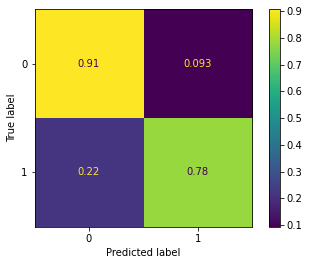

In [19]:
pipeline = utils.entrenar_y_realizar_prediccion_final_con_metricas(X, y, pipeline)

Este ensamble logra la mejor métrica ROC-AUC entre todos los modelos, a pesar de ser bastante similar a las obtenidas mediante 1-ArbolDeDecision y 2-RandomForest. Con la diferencia en que es el modelo con mejor Recall, debido a que la tasa de Falsos Negativos esta 2 puntos por debajo del Arbol de Decision y 6 por debajo de Random Forest. Sin embargo, obtiene peores resultados en cuanto a los Falsos Positivos, por lo cual no obtiene mejor Precision que dichos modelos.

### Predicción HoldOut

In [20]:
utils.predecir_holdout_y_generar_csv(pipeline, 'Predicciones/9-Ensambles.csv')